In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
from simple_attacks import SimpleAttack
attack = SimpleAttack()

In [3]:
enron_vec = pd.read_csv('data/enron_cleaned.csv')
enron_vec = enron_vec.fillna('')
bigram_vectorizer = CountVectorizer(ngram_range = (2, 2))
corpus_fitted = bigram_vectorizer.fit(enron_vec['clean_msg_no_lst'])

In [4]:
with open('models/rf_pkl', 'rb') as f:
    rf = pickle.load(f)
    
with open('models/mbayes_pkl', 'rb') as f:
    mbayes = pickle.load(f)
    
with open('models/lr_pkl', 'rb') as f:
    lr = pickle.load(f)
    
with open('models/svm_pkl', 'rb') as f:
    svm_SVC = pickle.load(f)
    
with open('models/knn_pkl', 'rb') as f:
    knn = pickle.load(f)

# Focused Attack
**Experiment:** Target Vincent Kaminski (Managing Director for Research in energy trading) by sending spam. Retrain models on the new spam. Determine recall on validation set and how many ham Vincent Kaminski emails were flagged as spam.

### Validation Set Emails that contain vince kaminski

In [5]:
def find_target_emails(email, target):
    email = str(email['clean_msg_no_lst'])
    if email.find(target) != -1:
        return email
    else:
        return np.nan

target = 'vince kaminski'

X_train, X_test, Y_train, Y_test = train_test_split(enron_vec[['clean_msg_no_lst']], enron_vec.target, random_state = 42, test_size = 0.2)
target_emails_df = X_test.apply(lambda email: find_target_emails(email, target), axis=1).to_frame('clean_msg_no_lst')
target_emails_df['target'] = Y_test
target_emails_df = target_emails_df[target_emails_df['clean_msg_no_lst'].notnull()]

X_focused_fitted = corpus_fitted.transform(target_emails_df['clean_msg_no_lst'])
Y_focused = target_emails_df['target']

### Baseline Random Forest

In [6]:
rf_predictions = rf.predict(X_focused_fitted)
print(classification_report(Y_focused, rf_predictions))
print(confusion_matrix(Y_focused, rf_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361

[[361]]


### Baseline Naive Bayes

In [7]:
mbayes_predictions = mbayes.predict(X_focused_fitted)
print(classification_report(Y_focused, mbayes_predictions))
print(confusion_matrix(Y_focused, mbayes_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361

[[361]]


### Baseline Logistic Regression

In [8]:
lr_predictions = lr.predict(X_focused_fitted)
print(classification_report(Y_focused, lr_predictions))
print(confusion_matrix(Y_focused, lr_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361

[[361]]


### Baseline SVM

In [9]:
svm_SVC_predictions = svm_SVC.predict(X_focused_fitted)
print(classification_report(Y_focused, svm_SVC_predictions))
print(confusion_matrix(Y_focused, svm_SVC_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361

[[361]]


### Baseline KNN

In [10]:
knn_predictions = knn.predict(X_focused_fitted)
print(confusion_matrix(Y_focused, knn_predictions))
print(classification_report(Y_focused, knn_predictions))

[[360   1]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361
           1       0.00      0.00      0.00         0

    accuracy                           1.00       361
   macro avg       0.50      0.50      0.50       361
weighted avg       1.00      1.00      1.00       361



/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Retrain Models on Updated Spam

In [23]:
attack_spam_df = attack.focused_attack(target, num_spam=20000)
train, _, _, _ = train_test_split(enron_vec[['clean_msg_no_lst', 'target']], enron_vec.target, random_state = 42, test_size = 0.2)
train = train.append(attack_spam_df).reset_index()
Y_train = train['target']
# corpus_fitted = bigram_vectorizer.fit(train['clean_msg_no_lst'])
X_train_fitted = corpus_fitted.transform(train['clean_msg_no_lst'])

In [24]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = None, random_state = 42, n_jobs = -1).fit(X_train_fitted, Y_train)

with open('models/rf_focused_pkl', 'wb') as files:
    pickle.dump(rf, files)

In [25]:
mbayes = MultinomialNB().fit(X_train_fitted, Y_train)

with open('models/mbayes_focused_pkl', 'wb') as files:
    pickle.dump(mbayes, files)

In [26]:
lr = LogisticRegression().fit(X_train_fitted, Y_train)

with open('models/lr_focused_pkl', 'wb') as files:
    pickle.dump(lr, files)

In [27]:
svm_SVC = svm.SVC(kernel = 'rbf', gamma =  0.01).fit(X_train_fitted, Y_train)

with open('models/svm_focused_pkl', 'wb') as files:
    pickle.dump(svm_SVC, files)

In [28]:
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train_fitted, Y_train)

with open('models/knn_focused_pkl', 'wb') as files:
    pickle.dump(knn, files)

# Focused Attack Impact

In [29]:
with open('models/rf_focused_pkl', 'rb') as f:
    rf = pickle.load(f)
    
with open('models/mbayes_focused_pkl', 'rb') as f:
    mbayes = pickle.load(f)
    
with open('models/lr_focused_pkl', 'rb') as f:
    lr = pickle.load(f)
    
with open('models/svm_focused_pkl', 'rb') as f:
    svm_SVC = pickle.load(f)
    
with open('models/knn_focused_pkl', 'rb') as f:
    knn = pickle.load(f)

### Random Forest

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       361
           1       0.00      0.00      0.00         0

    accuracy                           0.99       361
   macro avg       0.50      0.49      0.50       361
weighted avg       1.00      0.99      0.99       361

[[357   4]
 [  0   0]]


/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

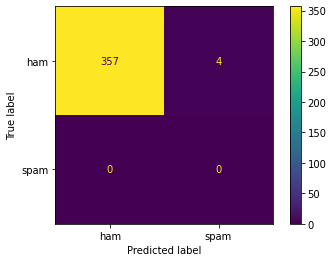

In [30]:
rf_predictions = rf.predict(X_focused_fitted)
print(classification_report(Y_focused, rf_predictions))
print(confusion_matrix(Y_focused, rf_predictions))

cm_rf = confusion_matrix(Y_focused, rf_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();

### Naive Bayes

In [31]:
mbayes_predictions = mbayes.predict(X_focused_fitted)
print(classification_report(Y_focused, mbayes_predictions))
print(confusion_matrix(Y_focused, mbayes_predictions))

# cm_mbayes = confusion_matrix(Y_focused, mbayes_predictions)
# cmd_mbayes = ConfusionMatrixDisplay(cm_mbayes, display_labels=['ham','spam'])
# cmd_mbayes.plot();

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361

[[361]]


### Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.91      0.96       361
           1       0.00      0.00      0.00         0

    accuracy                           0.91       361
   macro avg       0.50      0.46      0.48       361
weighted avg       1.00      0.91      0.96       361

[[330  31]
 [  0   0]]


/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

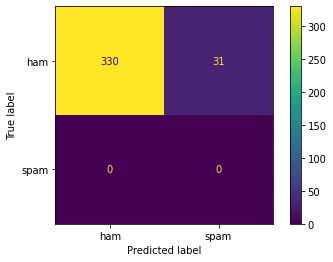

In [32]:
lr_predictions = lr.predict(X_focused_fitted)
print(classification_report(Y_focused, lr_predictions))
print(confusion_matrix(Y_focused, lr_predictions))

cm_lr = confusion_matrix(Y_focused, lr_predictions)
cmd_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['ham','spam'])
cmd_lr.plot();

### SVM

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       361
           1       0.00      0.00      0.00         0

    accuracy                           0.94       361
   macro avg       0.50      0.47      0.48       361
weighted avg       1.00      0.94      0.97       361

[[339  22]
 [  0   0]]


/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

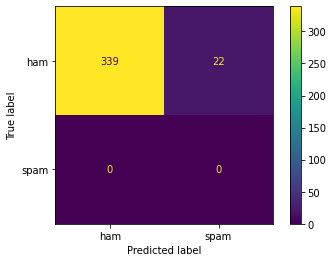

In [33]:
svm_SVC_predictions = svm_SVC.predict(X_focused_fitted)
print(classification_report(Y_focused, svm_SVC_predictions))
print(confusion_matrix(Y_focused, svm_SVC_predictions))

cm_svm = confusion_matrix(Y_focused, svm_SVC_predictions)
cmd_svm = ConfusionMatrixDisplay(cm_svm, display_labels=['ham','spam'])
cmd_svm.plot();

### KNN

[[177 184]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      0.49      0.66       361
           1       0.00      0.00      0.00         0

    accuracy                           0.49       361
   macro avg       0.50      0.25      0.33       361
weighted avg       1.00      0.49      0.66       361



/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mzaghi/CMPT413/email-spam-detection/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

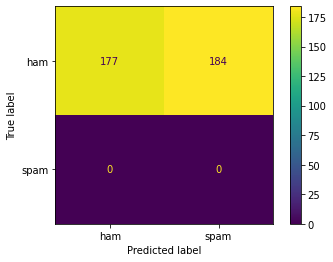

In [34]:
knn_predictions = knn.predict(X_focused_fitted)
print(confusion_matrix(Y_focused, knn_predictions))
print(classification_report(Y_focused, knn_predictions))

cm_knn = confusion_matrix(Y_focused, knn_predictions)
cmd_knn = ConfusionMatrixDisplay(cm_knn, display_labels=['ham','spam'])
cmd_knn.plot();

# Results

Total emails with the target *vince kaminski*: 365     
**Baseline Ham Recall (yes it is spam, but missclassified has ham (FP) => TP/(TP+FP))**    
Random Forest: 0  
Naive Bayes: 0  
Logistic Regression: 0  
SVM: 0  
KNN: 1   
**num_spam = 5000**    
Random Forest: 5   
Naive Bayes: 0   
Logistic Regression: 21   
SVM: 20  
KNN: 180  
**num_spam = 10000**     
Random Forest: 5   
Naive Bayes: 0  
Logistic Regression: 24   
SVM: 25  
KNN: 179   
**num_spam = 15000**       
Random Forest: 4     
Naive Bayes: 0       
Logistic Regression: 30      
SVM: 22  
KNN: 185  
**num_spam = 20000**         
Random Forest: 4       
Naive Bayes: 0        
Logistic Regression: 31       
SVM: 22    
KNN: 184      


<Figure size 432x288 with 0 Axes>

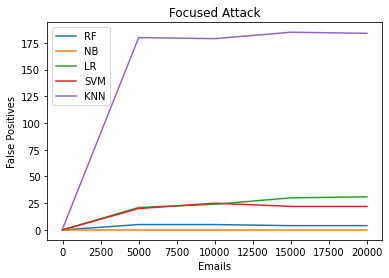

In [37]:
plt.figure()
plot_df = pd.DataFrame({
   'RF': [0, 5, 5, 4, 4],
   'NB': [0, 0, 0, 0, 0],
   'LR': [0, 21, 24, 30, 31],
   'SVM': [0, 20, 25, 22, 22],
   'KNN': [1, 180, 179, 185, 184]
   }, index=[0, 5000, 10000, 15000, 20000])
plot_df.plot(title ='Focused Attack')
plt.xlabel('Emails')
plt.ylabel('False Positives')
plt.show()